# <center> 3.2 - Визуализация. Ошибки модели</center> 

В предыдущем уроке про визуализацию мы смотрели, что можно почерпнуть из визуального представления данных: корреляции, пропуски, идеи для новых признаков. Теперь мы рассмотрим, как визуализация может нам помочь после того, как мы уже обучили какую-нибудь модель: визуализировать ошибки модели, отсеять лишние признаки, сделать выводы как можно улучшить точность в последующих экспериментах.

In [1]:
!pip install catboost sklearn shap seaborn -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import seaborn as sns; sns.set_theme()

In [3]:
train = pd.read_csv('../data/car_train.csv')   # car_info - информация про машины с таргетом
rides = pd.read_csv('../data/rides_info.csv') # rides_info - информация про поездки

In [4]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)

In [5]:
drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date']
cat_cols = ['car_type', 'fuel_type', 'model']

In [6]:
# заполним пропущенные значения медианным значением по столбцу
train.fillna(train.median(), inplace=True)

## Классификация

In [7]:
X = train.drop(drop_cols + ['target_reg','target_class'], axis=1, errors = 'ignore')
y = train['target_class']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli',
                         )

In [10]:
clf.fit( X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(clf.get_best_score())

Learning rate set to 0.109335
0:	learn: 2.0246838	test: 2.0257201	best: 2.0257201 (0)	total: 99.5ms	remaining: 1m 39s
50:	learn: 0.9732573	test: 1.0333384	best: 1.0333384 (50)	total: 255ms	remaining: 4.74s
100:	learn: 0.6918503	test: 0.7951926	best: 0.7951926 (100)	total: 360ms	remaining: 3.2s
150:	learn: 0.5937098	test: 0.7287818	best: 0.7287818 (150)	total: 477ms	remaining: 2.68s
200:	learn: 0.5279399	test: 0.6975797	best: 0.6975761 (199)	total: 588ms	remaining: 2.34s
250:	learn: 0.4962953	test: 0.6808884	best: 0.6808515 (243)	total: 720ms	remaining: 2.15s
300:	learn: 0.4525821	test: 0.6642880	best: 0.6642880 (300)	total: 915ms	remaining: 2.12s
350:	learn: 0.4285859	test: 0.6631553	best: 0.6616134 (313)	total: 1.05s	remaining: 1.94s
400:	learn: 0.4065998	test: 0.6597884	best: 0.6596319 (399)	total: 1.13s	remaining: 1.68s
450:	learn: 0.3802530	test: 0.6560621	best: 0.6558365 (438)	total: 1.25s	remaining: 1.52s
500:	learn: 0.3609973	test: 0.6563902	best: 0.6539781 (482)	total: 1.36s	re

In [11]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,mean_rating,34.625416
1,speed_max,32.962968
2,rating_min,11.380169
3,user_uniq,4.521437
4,model,3.113355
5,car_type,2.751093
6,user_ride_quality_median,2.281669
7,year_to_work,1.752869
8,distance_sum,1.674668
9,year_to_start,1.594838


## Визуализируем важность фичей модели из `Catboost`

Не стоит сильно доверять этому рейтингу важности, т.к. для сильно скоррелированных признаков импортанс делится пополам и они оба могут улететь вниз по важности.

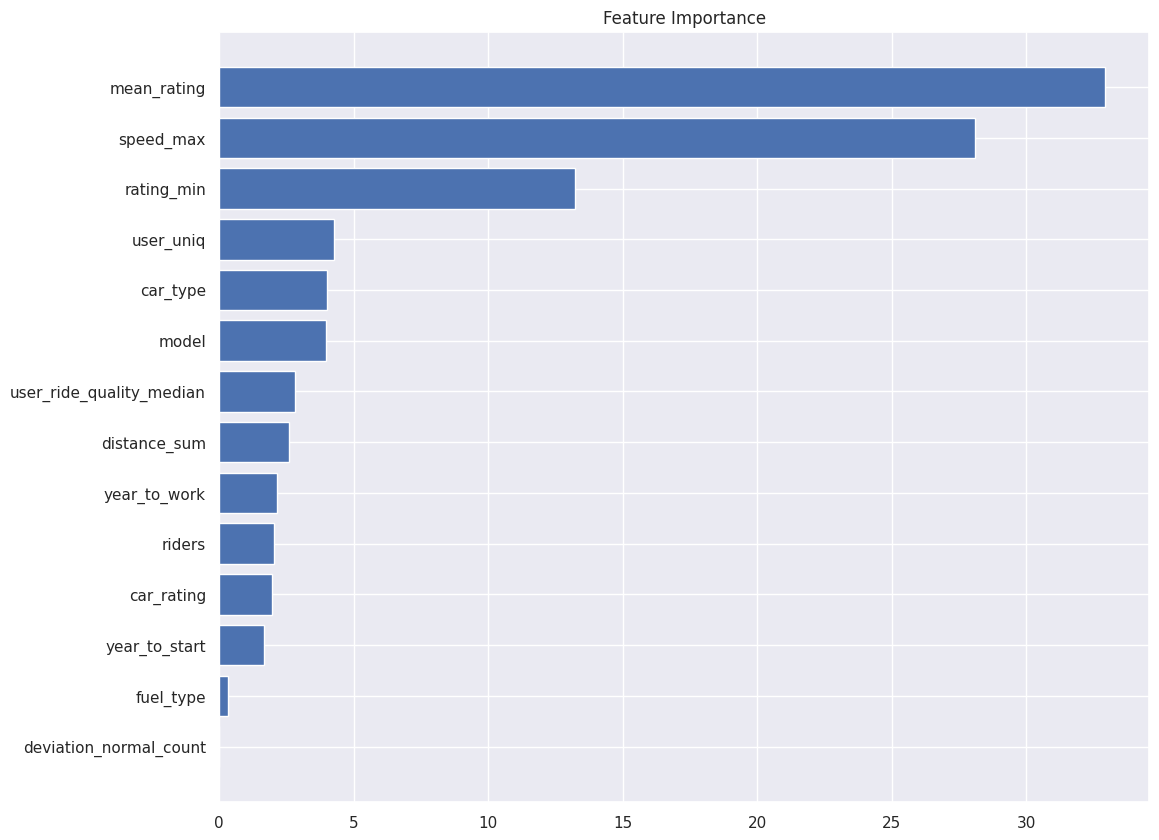

In [13]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

## Теперь построим график важности признаков при кросс-валидации с помощью SeaBorn

In [ ]:
from sklearn.model_selection import KFold

n_splits = 5
targets = ['target_class']
clfs = []
scores = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)

    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli',)

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 500, use_best_model = True, plot = False)

    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items()], dtype = 'float16'))
print('mean Recalls core --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))

(1869, 14) (1869,)
Learning rate set to 0.109335
0:	learn: 2.0243175	test: 2.0386745	best: 2.0386745 (0)	total: 2.17ms	remaining: 2.17s
500:	learn: 0.3944607	test: 0.6274056	best: 0.6252815 (440)	total: 716ms	remaining: 714ms
999:	learn: 0.2541675	test: 0.6343946	best: 0.6252815 (440)	total: 1.45s	remaining: 0us

bestTest = 0.6252814875
bestIteration = 440

Shrink model to first 441 iterations.
(1869, 14) (1869,)
Learning rate set to 0.109335
0:	learn: 2.0308156	test: 2.0346682	best: 2.0346682 (0)	total: 2.07ms	remaining: 2.07s
500:	learn: 0.3593367	test: 0.6460661	best: 0.6437758 (427)	total: 721ms	remaining: 718ms
999:	learn: 0.2102118	test: 0.6690695	best: 0.6437758 (427)	total: 1.49s	remaining: 0us

bestTest = 0.6437758012
bestIteration = 427

Shrink model to first 428 iterations.
(1870, 14) (1870,)
Learning rate set to 0.109336
0:	learn: 2.1825869	test: 2.1821489	best: 2.1821489 (0)	total: 877us	remaining: 877ms
500:	learn: 0.3599905	test: 0.5944812	best: 0.5939004 (497)	total: 78

Напишем функцию для отображения разброса важности признаков по фолдам.

Всего признаков 14 Усреднее по 5-ти моделям: 
На график нанесено топ-14 признаков


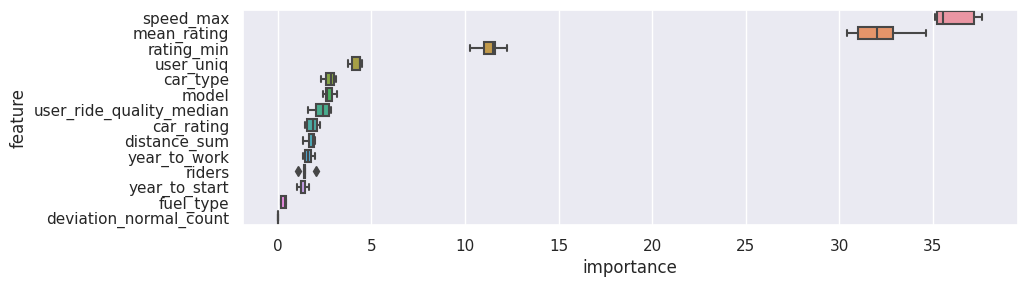

In [88]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(X, clfs, height = 0.20, top_n = 14)


## Посмотрим на графики важности более точных методов

## <center><b> Permutation importance </b></center> 

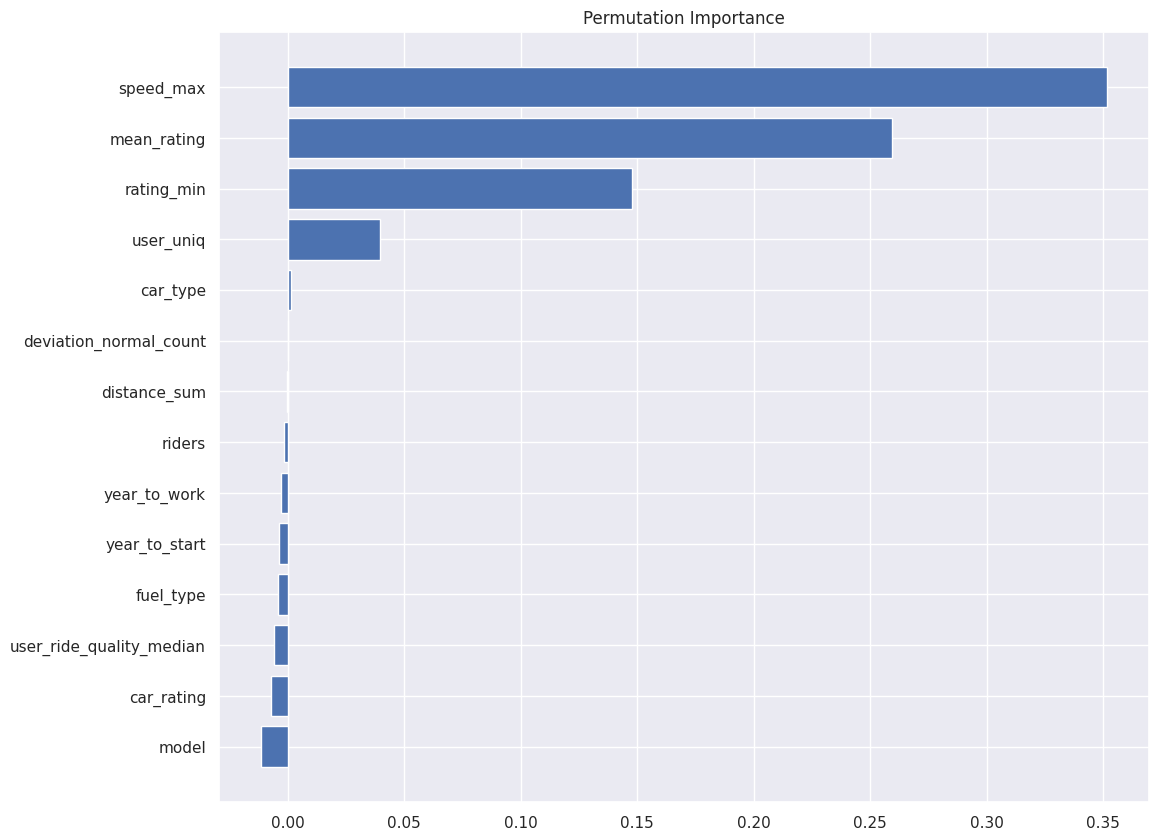

In [97]:
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

## <center><b> SHAP values </b></center> 

<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png">

В библиотеке SHAP для оценки важности признаков рассчитываются значения Шэпли (по имени американского математика и названа библиотека), она обладает богатым функционалом визуализации, который помогает легко и просто объяснить модель.

Для оценки важности фичи происходит оценка предсказаний модели с и без данной фичи.

In [19]:
# Библиотека shap бывает капризна в установке и может конфликтовать с другими пакетами
# Иногда помогает такой набор команд
#!pip uninstall opencv-python -y -q
#!pip install opencv-python shap -q

In [13]:
import shap
shap.initjs()

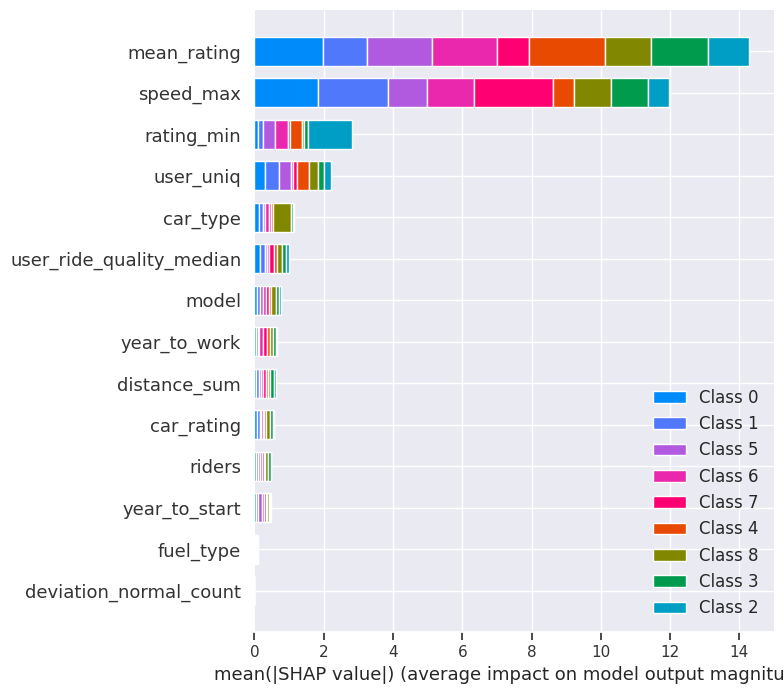

In [14]:
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

Class 0


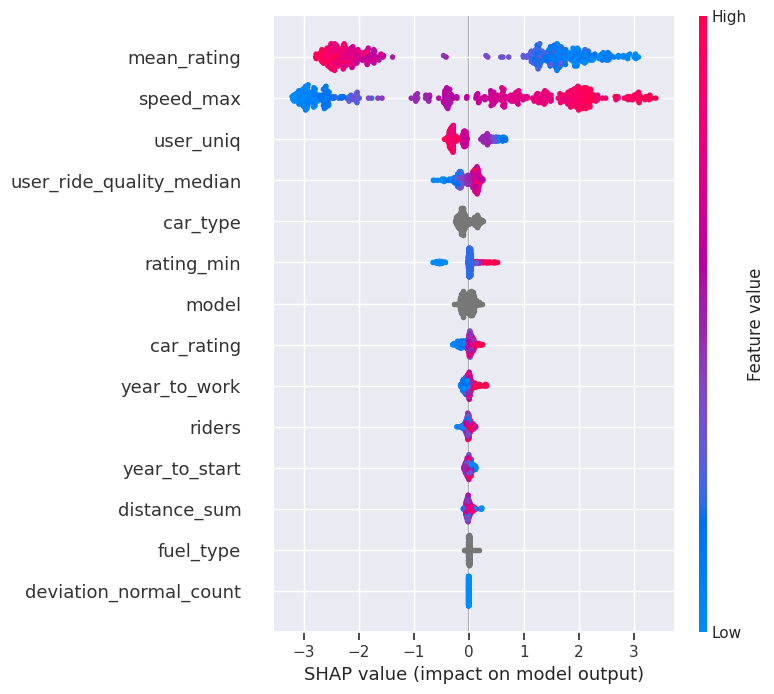

Class 1


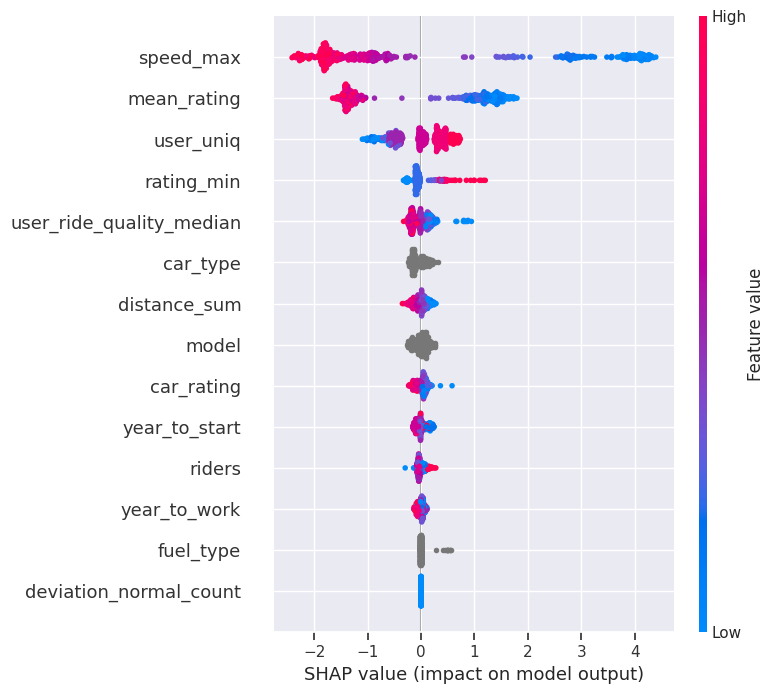

In [15]:
# Или на каждый класс по отдельности
for i in range(len(np.unique(y.values))):
    print(f'Class {i}')
    shap.summary_plot(shap_values[i], X_test, color_bar=True)
    if i == 1:
        break
#shap.summary_plot(shap_values[1], X_test, color_bar=False)

Как читать график:
* значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения фичи в ней

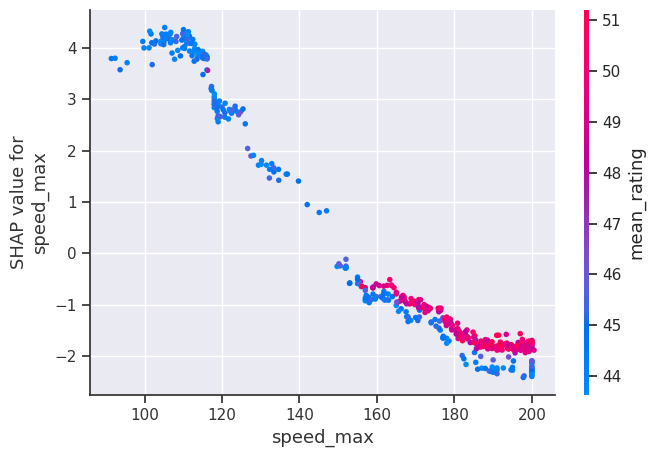

In [14]:
# так же можем посмотреть влияние отдельной фичи на конкретный класс с помощью dependence_plot 
shap.dependence_plot("speed_max", shap_values[1], X_test)

Одна из самых крутых фишек баблиотеки SHAP, это возможность посмотреть как модель опрделяет к какому классу относится конкретная машина, и какие признаки на это влияют.
Посмотрим на примере первой машины из тестовой выборки.

In [55]:
X_test.iloc[0]

model                       Volkswagen ID.4 
car_type                             premium
fuel_type                            electro
car_rating                              4.28
year_to_start                           2017
riders                                114851
year_to_work                            2020
mean_rating                        51.402299
distance_sum                 11634739.066409
rating_min                               0.1
speed_max                         190.915943
user_ride_quality_median           -4.022916
deviation_normal_count                   174
user_uniq                                148
Name: 1720, dtype: object

In [57]:
# поломка "engine_fuel" это 4 класс
y_test.iloc[0]

'engine_fuel'

В этом нам помогут `force_plot` и просто "пушечный" вид графика `waterfall_plot`.
Можно посмотреть на вклад каждого признака в то, что модель не отнесла поломку машины к классу 0 и отнесла к классу 4

In [16]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=X_test.columns)

In [17]:
shap.force_plot(explainer.expected_value[0], shap_values[4][0], feature_names=X_test.columns)

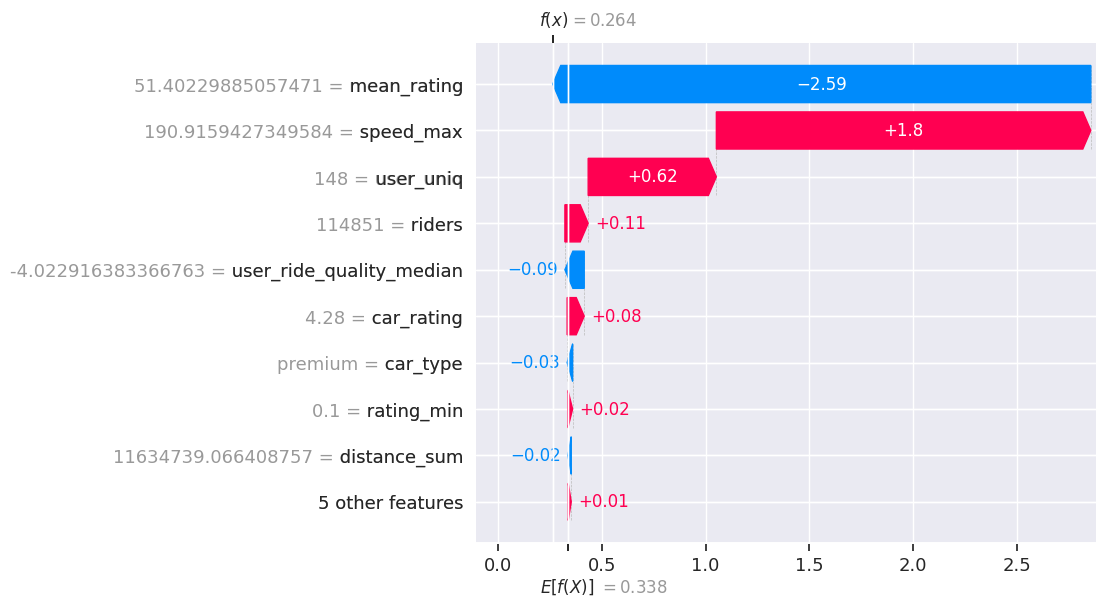

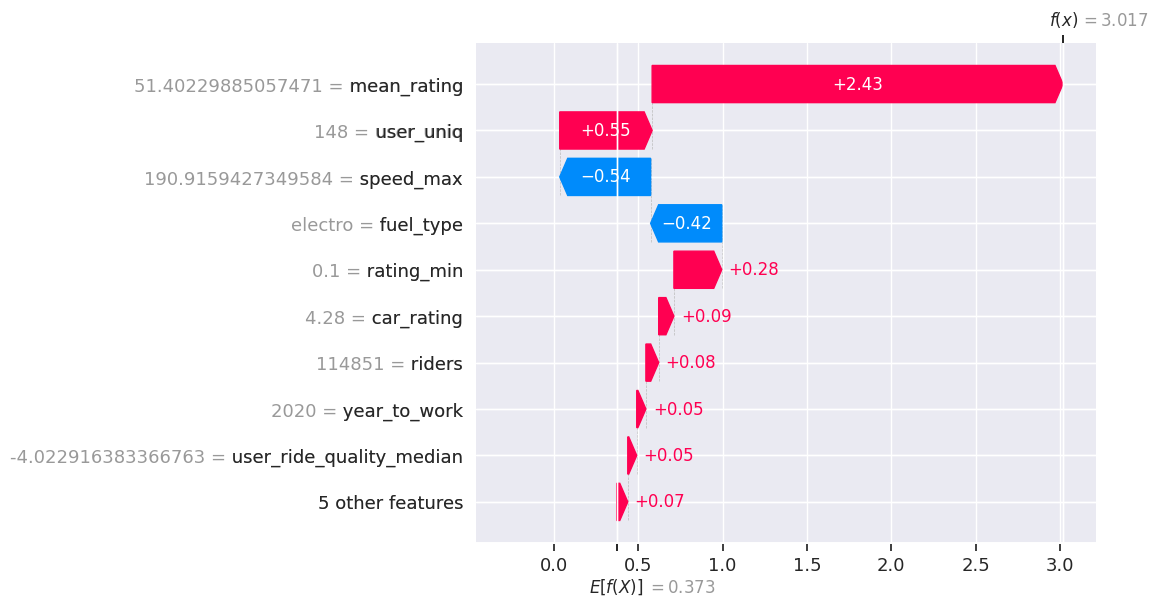

In [18]:
# waterfall_plot показывает численное влияние каждого признака
s_values = explainer(X_test)
shap.waterfall_plot(s_values[0][:, 0])

shap.waterfall_plot(s_values[0][:, 4])

В библиотеке [SHAP](https://shap.readthedocs.io/en/latest/index.html) есть ещё большое количество других графиков, а мы показали самые интересные и часто используемые.

# <center> classification report </center>

In [15]:
y_pred = clf.predict(X_test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = y_pred, target_names=clf.classes_))

                 precision    recall  f1-score   support

    another_bug       0.94      0.86      0.90        58
      break_bug       0.63      0.55      0.59        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.74      0.88      0.80        49
    engine_fuel       0.78      0.67      0.72        58
engine_ignition       0.67      0.50      0.57        58
engine_overheat       0.49      0.73      0.58        48
     gear_stick       0.57      0.59      0.58        51
    wheel_shake       0.67      0.67      0.67        39

       accuracy                           0.71       468
      macro avg       0.72      0.72      0.71       468
   weighted avg       0.73      0.71      0.71       468



## <center> Матрица смежности </center>

Посмотрим в каких классах модель больше всего ошибается с помощью матрицы смежности

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 45)

# plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(12,12)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True)

In [29]:
from ..src.utils import *

ImportError: attempted relative import with no known parent package

In [27]:
plot_confusion(Y_test = y_test, Y_test_pred = y_pred)#, labels = clf.classes_ )

NameError: name 'plot_confusion' is not defined

Значения диагонали сверху вниз слева направо – это число верно предсказанных значений. Чем темнее квадрат, тем больше верных ответов.

In [ ]:
# cm = confusion_matrix(y_test, pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)
# disp.plot()

Можно сделать вывод, что модель больше всего путается между классами: 1 - 2, 1 - 5, 1- 6, 2 - 3, 5 - 6. В целом, видно, что 1 и 5 классы хуже отделяются.

## Отрисуем дерево модели

In [ ]:
clf.plot_tree(
    tree_idx=0,
    pool=val_dataset
)

## <center> Partial plots </center>

 Посмотрим как топовые фичи влияют на прогноз модели

In [22]:
len(np.unique(y.values))

9

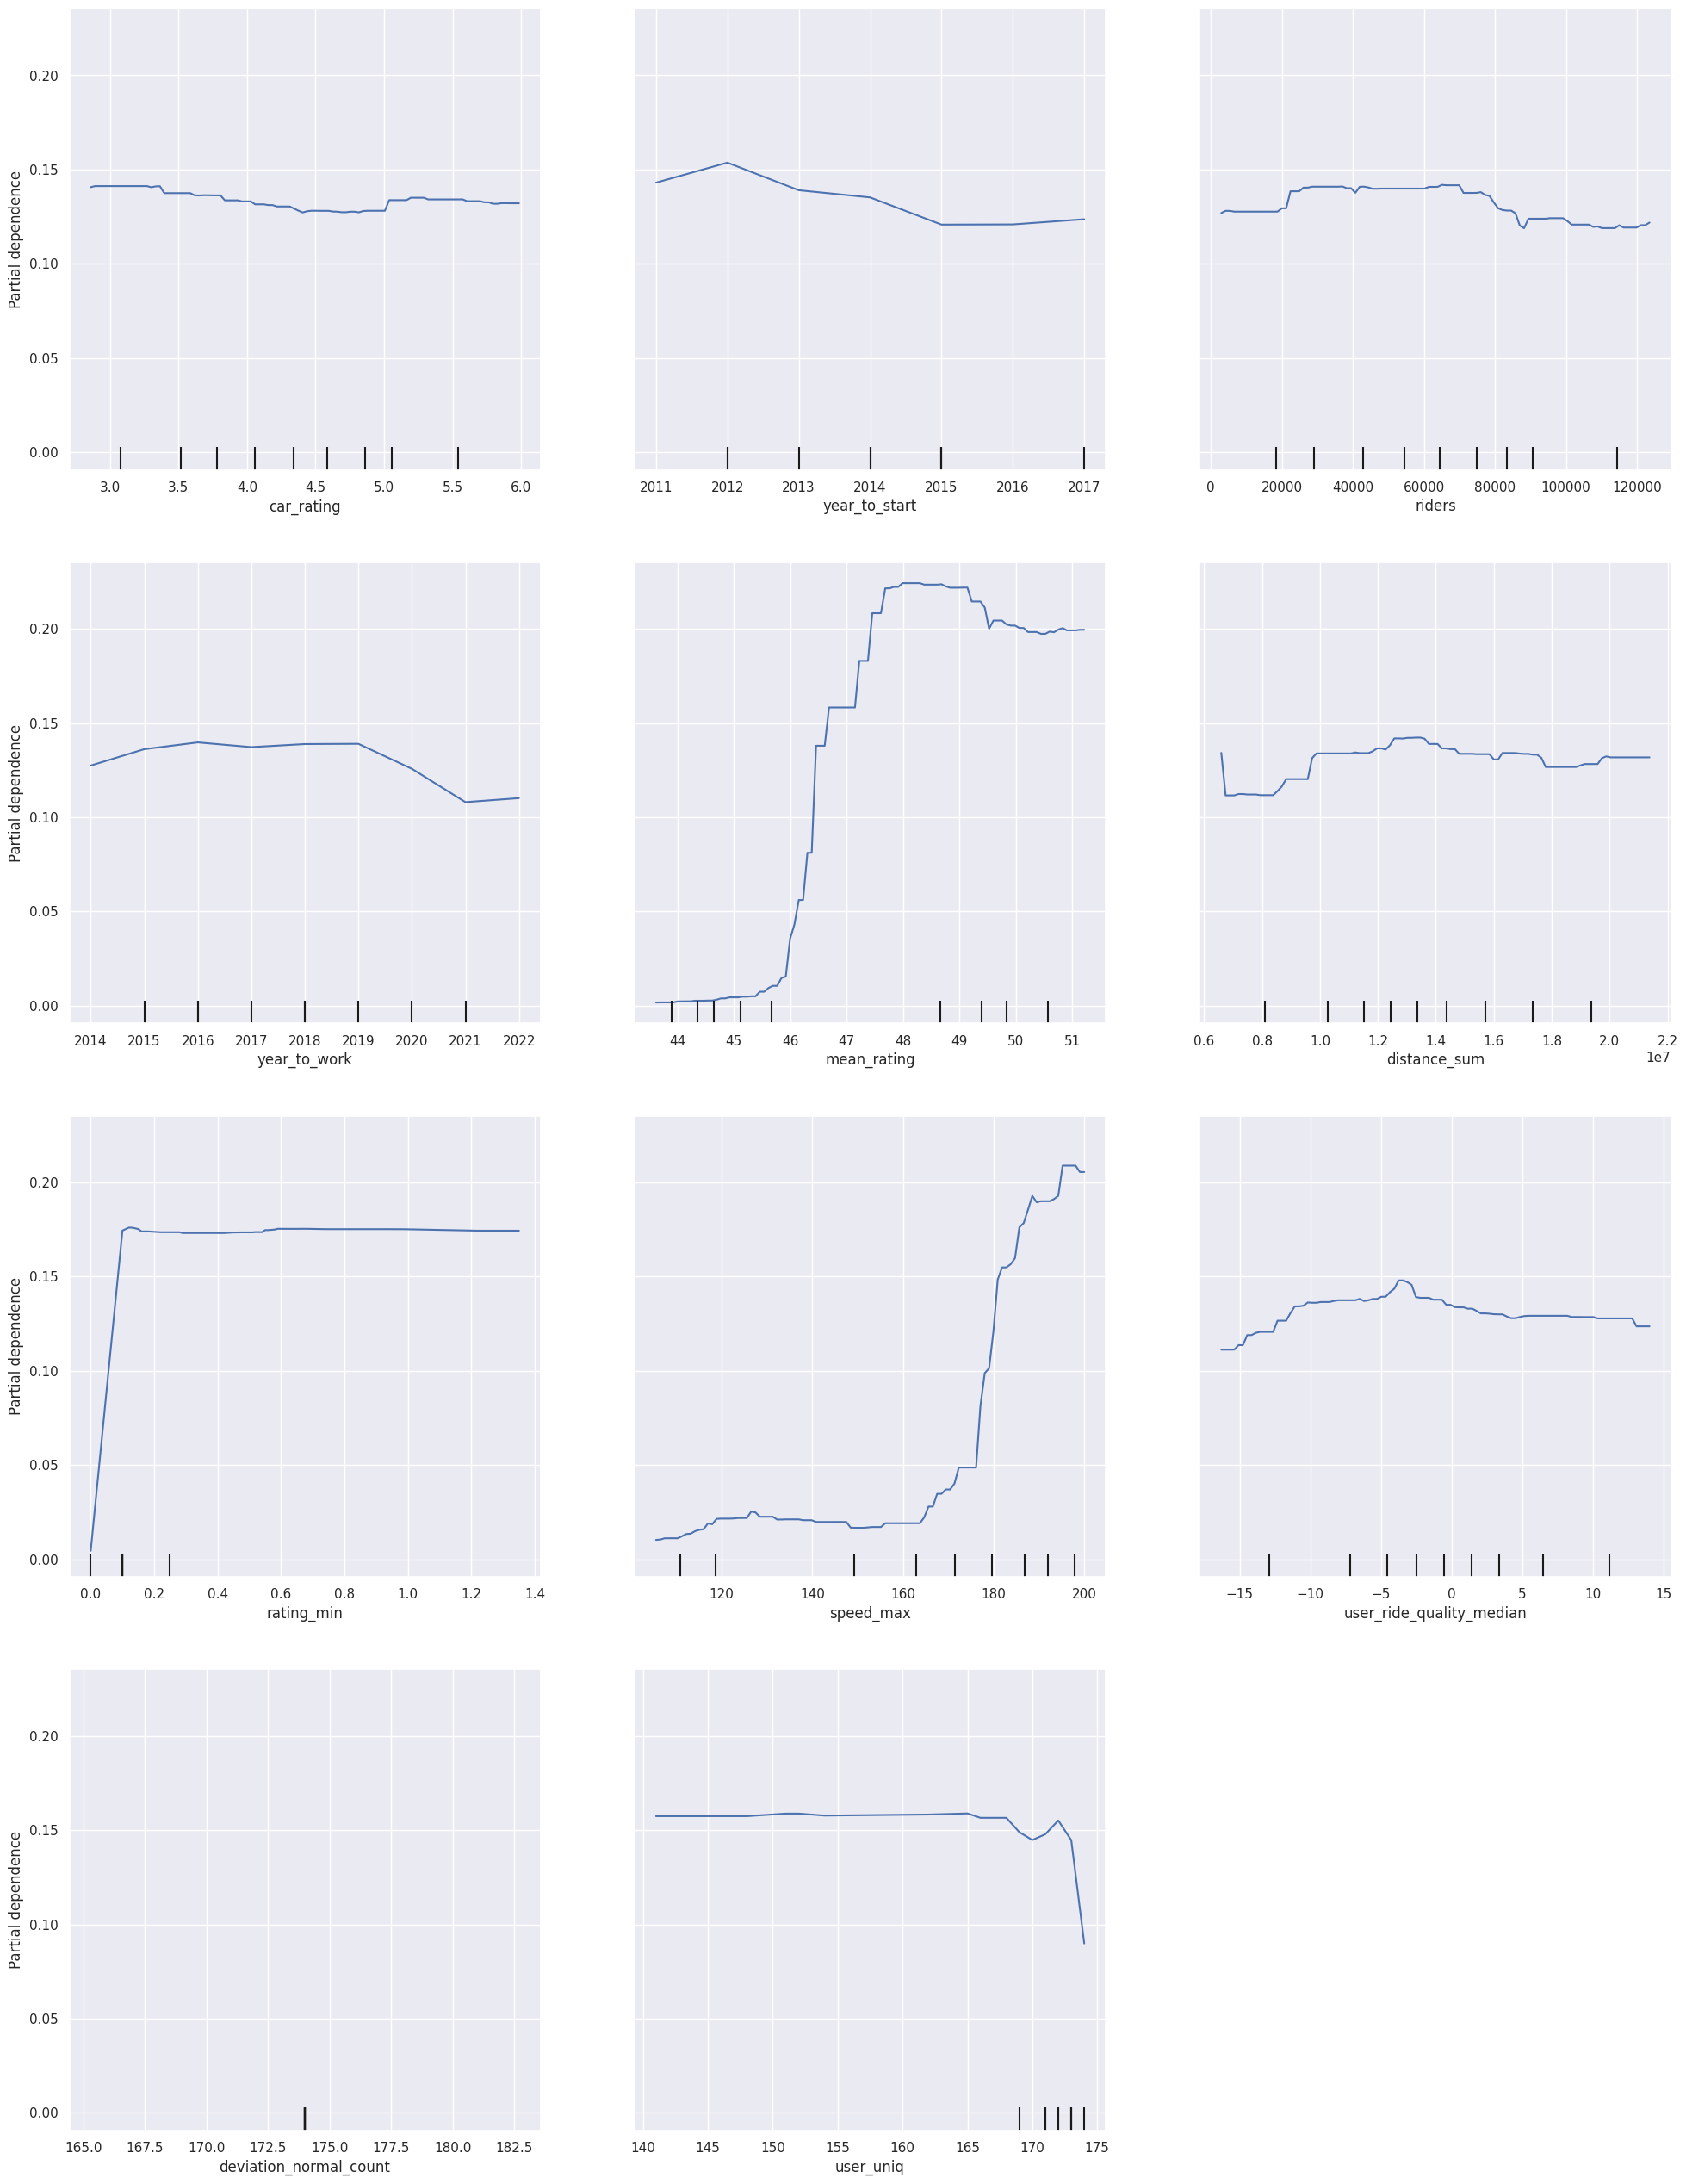

In [23]:
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize']=(24,32)
features = X.drop(cat_cols, axis=1).columns
PartialDependenceDisplay.from_estimator(clf, X_test, features, target='engine_overheat', n_cols=3,
    n_jobs=-1,
    random_state=42)

## Регрессия 📈

In [78]:
X = rides_info.drop(drop_cols + ['target_reg','target_class'], axis=1)
y = rides_info['target_reg']

NameError: name 'rides_info' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regr = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                         )

In [ ]:
regr.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(regr.get_best_score())

# Feature Importance

# Diff Targets
# График (pred - True) VS (True + pred) (Дьяноков)

# Матрица смежности для регрессии (Разбиваем на бины)
# Визуальный анализ ошибок
# Шифтованные фичи, важные для модели
# Object Importance или очень большие ошибки